In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from scipy.fft import fft, fftfreq

n size: 5214


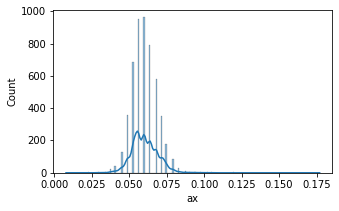

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


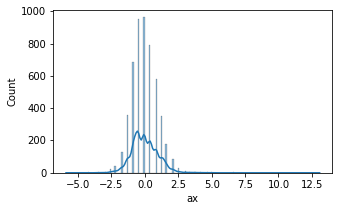

Number of records: 5214
Max Amplitude within 0.13 and 0.66 Hz frequency:
X-Axis: 1.4180313402839573e-13
Y-Axis: 185.58267929093077
Z-Axis: 432.66947279733495
Max amplitude chosen: 432.66947279733495
Frequency of chosen amplitude: 0.24004611837048423
Respiratory Rate (bpm): 14.402767102229054


In [ ]:
# [0.155, 0.16199999999999992, 0.24399999999999997] (bien do)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.signal import butter, filtfilt
from scipy import signal
import scipy as sp
import scipy.fftpack


cols = ['time', 'ax', 'ay', 'az', 'x', 'y', 'z']
path = r'/respiration_50hz_1.TXT'
df = pd.read_csv(path, names = cols)
df.z = df.z.astype(str)
df.z = [x.replace(';', '') for x in df.z]
df.z = df.z.astype(float)

data = df[['ax', 'ay', 'az']]
print('n size:', len(data))
data.to_csv(r'/RR_Nhat (1).csv')
input_file_path = r'/RR_Nhat (1).csv'

plt.figure(figsize = (5,3))
sns.histplot(data = data.ax, kde = True)
plt.show()

def normalize(data):
    for i in (data.columns): 
        data[i]= sp.stats.zscore(data[i])
    return data

data1 = normalize(data)
plt.figure(figsize = (5,3))
sns.histplot(data = data1.ax, kde = True)
plt.show()

sampling_frequency = 50; Fs = 50  #20 hertz
average_filter_window_duration_br = 10

def normalize(data):
    for i in range(0,3): 
        data[:,i]= sp.stats.zscore(data[:,i])
    return data


def apply_average_filter(data, window):
    for i in range(0,3):
        data[:, i] = np.array(pd.Series(data[:, i]).rolling(window = window).mean())
    return data

# plot data
def plot(data, title, plot_save_path):
    N = len(data)
    y = np.linspace(0, N/Fs, N)
    plt.plot(y, data)
    plt.title(title)
    plt.ylabel('Acc Ax')
    plt.xlabel('time (s)')
    plt.close()

def draw_plot(plot_save_path):
    if(True):
        pass
    else:
        plt.draw()
        plt.pause(5)
    
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5*fs
    low = lowcut/ nyq
    high = highcut/nyq
    b,a = butter(order, [low, high], btype = 'band')
    
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b,a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b,a,data)   # output from the filter, input = data
    return y

# giving specific parameters to get the actual output
def apply_bandpass_butterworth_filter(data, low_cutoff_freq, high_cutoff_freq):
    order = 10
    y = butter_bandpass_filter(data, lowcutoff_freq, high_cutoff_freq, sampling_frequency, order)
    return y

# fusing components - module of data with 3 axises
#def aggrefate_components(data):
#  return np.array(list(map(lambda c: np.sqrt(np.sum(np.square(c))) , data)), dtype=np.float64)

def aggrefate_components(df):
    scalar = StandardScaler()
    scaled_data = pd.DataFrame(scalar.fit_transform(df)) #scaling the data
    pca = PCA(n_components = 1)
    pca.fit(scaled_data)
    data_pca = pca.transform(scaled_data)
    data_pca = pd.DataFrame(data_pca,columns=['PC1'])
    return np.array(data_pca)


def fft(acc_data, f_low, f_high, plot_save_path):
    acc_data = acc_data[~np.isnan(acc_data)]   # loại bỏ các điểm dữ liệu NaN
    acc_data = sp.signal.detrend(acc_data)     # loại bỏ xu hướng tuyến tính trong bộ dữ liệu
    N = len(acc_data)                          
    fft_data = sp.fftpack.fft(acc_data)
    f = np.linspace(0, N/Fs, N) #tạo vector tần số, khảo sát các tần số với tần số lấy mẫu Fs 
    plt.plot(f, np.abs(fft_data))
    plt.plot(f, np.abs(fft_data))
    plt.xlabel('Frequency in Hertz [Hz]')
    plt.ylabel('Magnitude')
    plt.title('FFT')
    draw_plot(plot_save_path)
    plt.close()
    max_amp = 0
    max_index = 0
    index = 0
    for c in fft_data:
        if f[index] < f_low or f[index] > f_high:
            index = index + 1
            continue;
        real = np.real(c)
        img = np.imag(c)
        amp = np.sqrt(real*real + img*img)
        if max_amp < amp:
            max_amp = amp
            max_index = index
        index += 1
    return max_amp, f[max_index]  # trả về tần số và biên độ lớn nhất tương ứng
    
def calculate_breathing_rate(normalized_data):
    smooth_data = apply_average_filter(normalized_data, average_filter_window_duration_br)
    smooth_data = np.array(list(filter(lambda row: np.isfinite(np.sum(row)), smooth_data)), dtype=np.float64)
    plot(smooth_data[:,0], 'Smoothened Accelerometer Data ', r'C:\Users\ADMIN\OneDrive\Desktop\Respiration dataset\smart-sensor-master\smart-sensor-master\plots\bio_watch\smoothened_ax.png')
    
    #apply butterworth filter
    amp_to_freq = {}
    breathing_low_freq = 0.13
    breathing_high_freq = 0.66
    print('Max Amplitude within 0.13 and 0.66 Hz frequency:')
    br_x_amp, br_x_f = fft(smooth_data[:,0], breathing_low_freq, breathing_high_freq, r'C:\Users\ADMIN\OneDrive\Desktop\Respiration dataset\smart-sensor-master\smart-sensor-master\plots\br_fft_xaxis.png')
    amp_to_freq[br_x_amp] = br_x_f
    print('X-Axis:', br_x_amp)
    br_y_amp, br_y_f = fft(smooth_data[:,1], breathing_low_freq, breathing_high_freq, r'C:\Users\ADMIN\OneDrive\Desktop\Respiration dataset\smart-sensor-master\smart-sensor-master\plots\br_fft_yaxis.png')
    amp_to_freq[br_y_amp] = br_y_f
    print('Y-Axis:', br_y_amp)
    br_z_amp, br_z_f = fft(smooth_data[:,2], breathing_low_freq, breathing_high_freq, r'C:\Users\ADMIN\OneDrive\Desktop\Respiration dataset\smart-sensor-master\smart-sensor-master\plots\br_fft_zaxis.png')
    amp_to_freq[br_z_amp] = br_z_f
    print('Z-Axis:', br_z_amp)
    br_max_amp = max([br_x_amp, br_y_amp, br_z_amp])

    print("Max amplitude chosen:", br_max_amp)
    print("Frequency of chosen amplitude:", amp_to_freq[br_max_amp])
    print("Respiratory Rate (bpm):", 60*amp_to_freq[br_max_amp])
    return 60*amp_to_freq[br_max_amp]
def bio_watch(data, sampling_freq):
    global sampling_frequency
    sampling_frequency = sampling_freq
    normalized_data = normalize(data)
    br = calculate_breathing_rate(normalized_data)
    return br
if __name__ == '__main__':
    data = pd.read_csv(input_file_path).values
    print("Number of records:", len(data))
    bio_watch(data, sampling_frequency)



n size: 5214


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


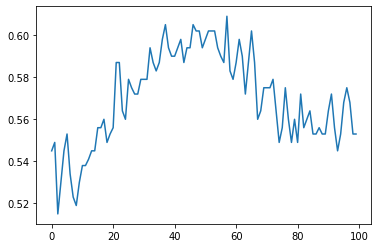

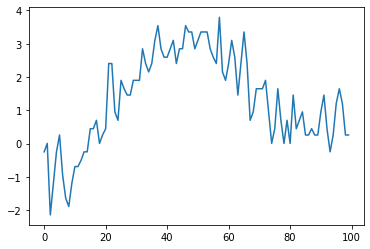

In [ ]:
cols = ['time', 'ax', 'ay', 'az', 'x', 'y', 'z']
path = r'/respiration_50hz_1.TXT'
df = pd.read_csv(path, names = cols)
df.z = df.z.astype(str)
df.z = [x.replace(';', '') for x in df.z]
df.z = df.z.astype(float)
data = df[['ax', 'ay', 'az']]
plt.figure()
plt.plot(data.ay[:100])
def normalize(data):
    for i in range(0,3): 
        data.iloc[:,i]= sp.stats.zscore(data.iloc[:,i])
    return data

# average filter for window (data segmentation)
def apply_average_filter(data, window):
    for i in range(0,3):
        data.iloc[:, i] = np.array(pd.Series(data.iloc[:, i]).rolling(window=window).mean())
    return data

print('n size:', len(data))
data1 = normalize(data)
plt.figure()
plt.plot(data1[:100].ay)



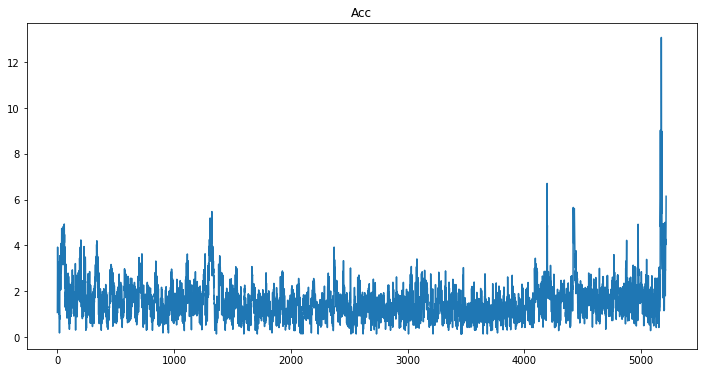

In [ ]:
#calculate RMS value
#import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

from matplotlib import interactive
figure1 = plt.figure(figsize = (12, 6))
plt.title("Acc")
rms_acc = (data['ax']**2+ data['ay']**2+ data['az']**2)**0.5
plt.plot(rms_acc)
interactive(True)
plt.show()
rms_acc = np.array(rms_acc)

In [ ]:
rms_acc
rms_acc.shape

(5214,)

In [ ]:
def normalize(data):
    data= sp.stats.zscore(data)
    return data


def apply_average_filter(data, window):
    data= np.array(pd.Series(data).rolling(window = window).mean())
    return data

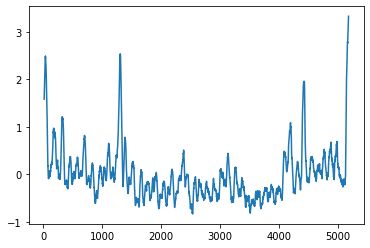

In [ ]:

rms1 = rms_acc.flatten() #flatten to 1-D array (but it is existently 1-D array)
rms1
rms1 = normalize(rms1)
rms1
rms1 = apply_average_filter(rms1, 50)

rms1 = rms1[30:]
rms1
plt.figure()
plt.plot(rms1)

In [ ]:
#THE PEAK DETECTION FUNCTION
def peak_finding(data,window_size):
    """
    find values and positions of peaks in a given time series data. 
    return a list of tuples [(x1, max1), (x2, max2),..,(xn, maxn)]
    
    data :       a given time series data
    window_size: look for peaks in a box of "window_size" size

    """
    data_extended = np.concatenate([np.zeros(window_size),data,np.zeros(window_size)])
    max_list = []
        
    for i,value in enumerate(data_extended):
        if (i >= window_size) and (i < len(data_extended)-window_size):
            try:
                max_left = data_extended[(i-window_size):i+1].max()
                max_right = data_extended[i:(i+window_size)+1].max()
                chek_value = data_extended[i] - ((max_left+max_right)/2)
            except ValueError:
                 pass
                
            if (chek_value >=0):
                max_list.append((i-window_size,data[(i-window_size)]))
    return max_list

In [ ]:
N_ref = 40
#bien luan tim cua so phu hop
def finding_w(N_ref, data):
    delta = 5
    optimal_w = 0
    for w in np.arange(20,80,5):
        n = len(peak_finding(data,w))
        if np.abs(n-N_ref) <= delta:
            delta = (n-N_ref)
            optimal_w = w
    return [delta, optimal_w]
a = finding_w(N_ref,rms1)
a

[0, 50]

In [ ]:
for w in np.arange(10,600,5):
  print(w)

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595


In [ ]:
#Find Peaks
# Find peaks with a windows size of 24
rm = peak_finding(rms1, 2000 )
x_peaks_24 = [ x for x,y in rm ]
y_peaks_24 = [ y for x,y in rm ]

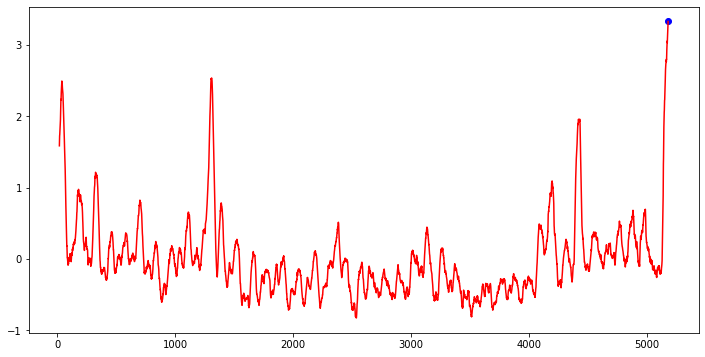

In [ ]:
#Graphs
#Graph for peaks with windows_size = 24
# create figure
fig = plt.figure(figsize=(12,6))
# plot graphs
plt.plot(rms1,color='red');

# Peaks with a windows size of 4
plt.scatter(x_peaks_24,y_peaks_24,color='blue');

In [ ]:
Nmin = 5
for w in np.arrange(10,5,600):
  N = len()


In [ ]:
len(rm)

40